In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import scipy
from collections import Counter

##Import any other packages you may need here

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('Data_Entry_2017.csv')
all_xray_df.sample(3)

data_sample = pd.read_csv('sample_labels.csv')
data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
504,00002625_003.png,No Finding,3,2625,044Y,M,PA,2048,2500,0.168,0.168
452,00002395_029.png,No Finding,29,2395,062Y,F,AP,2500,2048,0.168,0.168
1882,00009892_049.png,No Finding,49,9892,062Y,F,AP,2500,2048,0.168,0.168


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## size of NIH data
len(all_xray_df)

112120

In [4]:
#size sample data
len(data_sample)

5606

In [5]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:#leave out empty labels 
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
12103,00003154_000.png,Atelectasis,0,3154,70,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77297,00018983_001.png,No Finding,1,18983,51,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
90004,00022367_000.png,Nodule,0,22367,47,F,PA,2544,2816,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6]:
all_labels = np.unique(list(chain(*data_sample['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data_sample[c_label] = data_sample['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
222,00001230_007.png,Infiltration,7,1230,033Y,M,PA,2992,2991,0.143,...,0,0,0,1,0,0,0,0,0,0
2077,00010752_003.png,No Finding,3,10752,061Y,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
4199,00020631_004.png,No Finding,4,20631,047Y,M,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0


In [7]:
#Number of all disease labels
len(all_labels)

15

In [8]:
#concise summary of the main data
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  Atelectasis                  112120 non-null  float64
 13 

In [9]:
#concise summary of the sample data
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
 11  Atelectasis                  5606 non-null   int64  
 12  Cardiomegaly                 5606 non-null   int64  
 13  Consolidation     

In [10]:
#Relative frequency of each disease in the main data
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

In [11]:
#relative frequency of each disease in the sample data
data_sample[all_labels].sum()/len(data_sample)

Atelectasis           0.090617
Cardiomegaly          0.025152
Consolidation         0.040314
Edema                 0.021049
Effusion              0.114877
Emphysema             0.022654
Fibrosis              0.014984
Hernia                0.002319
Infiltration          0.172494
Mass                  0.050660
No Finding            0.542990
Nodule                0.055833
Pleural_Thickening    0.031395
Pneumonia             0.011060
Pneumothorax          0.048341
dtype: float64

In [12]:
#the data in the two Cells sbove reveal the statistics of diseases in main and sample data are similar

Text(0.5, 0, 'Diagnoses')

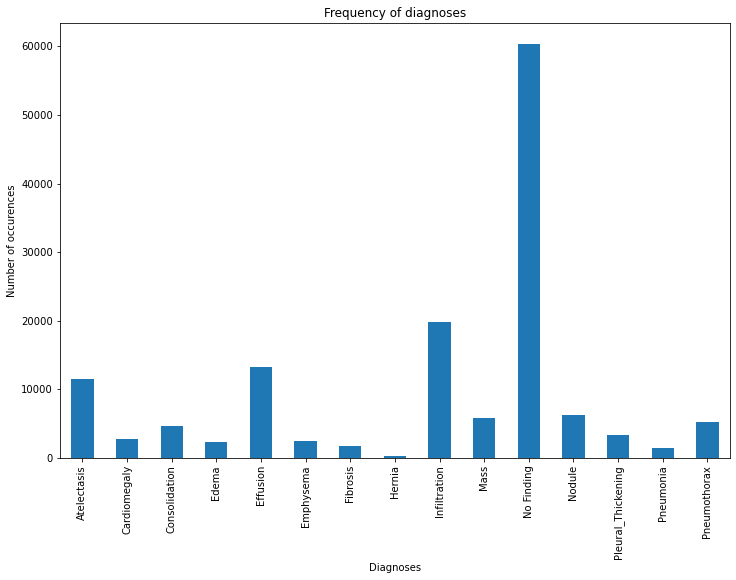

In [13]:
#Checking the relative frequencies of the different diagnoses
plt.figure(figsize= (12,8))
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set_title("Frequency of diagnoses")
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Diagnoses')


In [14]:
#Number of pneumonia diagnoses
all_xray_df['Pneumonia'].sum()

1431.0

In [15]:
#Number of non-pneumonia diagnoses
all_xray_df.shape[0]- all_xray_df['Pneumonia'].sum()

110689.0

Text(0.5, 17.19999999999999, 'Diagnoses')

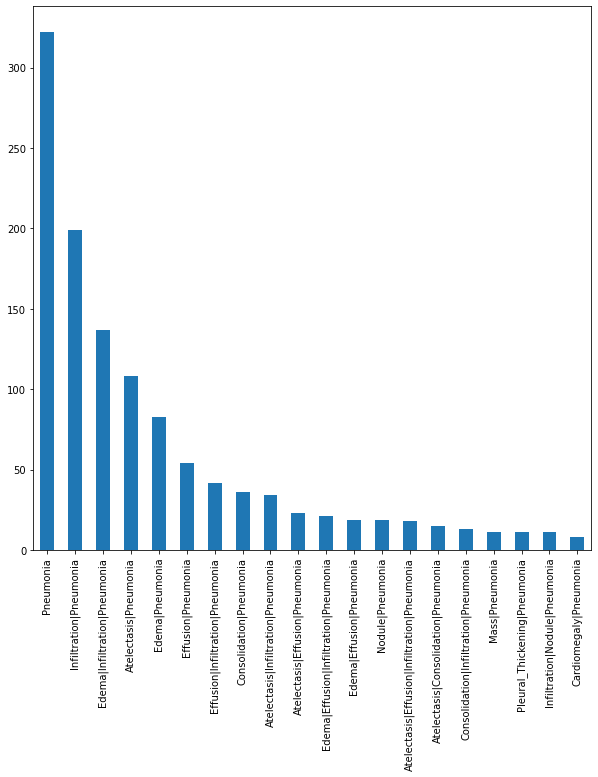

In [16]:
#distribution of 20 most common co-morbidities
plt.figure(figsize= (10,10))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')
ax.set_title("20 most common comorbidities")
ax.set_ylabel('Number of occurences')
ax.set_xlabel('Diagnoses')


In [17]:
#Number of diseases per patient
all_xray_df['Patient ID'].sum()

1608516321

In [18]:
Number = all_xray_df['Patient ID']
len(Number)

112120

In [19]:
#Number of labels per patient
a = dict(Counter(Number))
print (a)

{1: 3, 2: 1, 3: 8, 4: 1, 5: 8, 6: 1, 7: 1, 8: 3, 9: 1, 10: 1, 11: 9, 12: 1, 13: 47, 14: 1, 15: 1, 16: 1, 17: 3, 18: 1, 19: 1, 20: 3, 21: 2, 22: 2, 23: 5, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 2, 31: 1, 32: 61, 33: 1, 34: 2, 35: 2, 36: 1, 37: 1, 38: 8, 39: 5, 40: 4, 41: 7, 42: 9, 43: 1, 44: 3, 45: 1, 46: 1, 47: 8, 48: 1, 49: 3, 50: 4, 51: 1, 52: 2, 53: 2, 54: 10, 55: 1, 56: 2, 57: 5, 58: 1, 59: 2, 60: 1, 61: 26, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 3, 68: 1, 69: 1, 70: 1, 71: 9, 72: 1, 73: 10, 74: 1, 75: 2, 76: 1, 77: 1, 78: 3, 79: 1, 80: 6, 81: 1, 82: 1, 83: 1, 84: 2, 85: 1, 86: 3, 87: 2, 88: 1, 89: 1, 90: 11, 91: 11, 92: 4, 93: 3, 94: 1, 95: 1, 96: 9, 97: 1, 98: 1, 99: 14, 100: 2, 101: 1, 102: 1, 103: 12, 104: 2, 105: 6, 106: 1, 107: 2, 108: 2, 109: 7, 110: 1, 111: 1, 112: 3, 113: 2, 114: 1, 115: 2, 116: 41, 117: 2, 118: 17, 119: 2, 120: 1, 121: 10, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 11, 128: 1, 129: 2, 130: 1, 131: 3, 132: 7, 133: 3, 134: 1, 135: 2, 136: 1, 137: 2

In [20]:
len(a)

30805

Text(0, 0.5, 'Number of diagnoses')

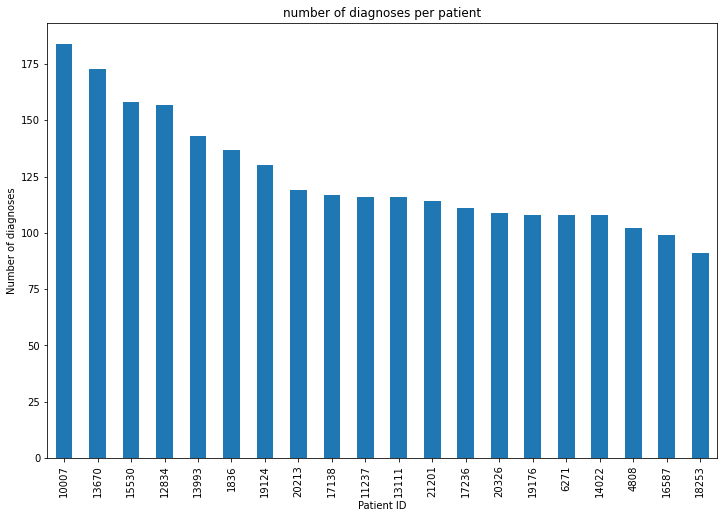

In [21]:
#20 patients with highest diagnoses
plt.figure(figsize=(12,8))
Number.value_counts()[0:20].plot(kind='bar')
plt.title('number of diagnoses per patient')
plt.xlabel('Patient ID')
plt.ylabel('Number of diagnoses')

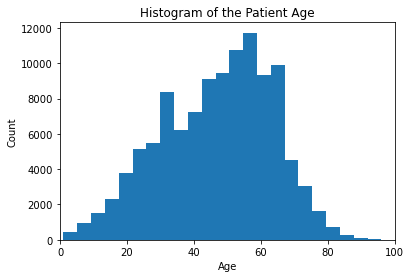

In [22]:
#Distribution of patients' age
plt.hist(all_xray_df['Patient Age'],bins=100);
plt.xlim(0,100);
plt.title('Histogram of the Patient Age')
plt.xlabel('Age')
plt.ylabel('Count');

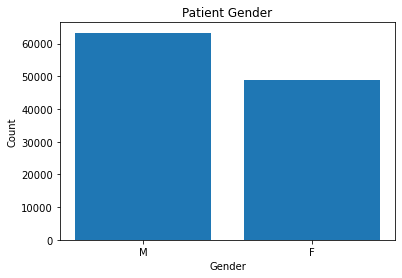

In [23]:
#Distribution of patients' gender
Gender=all_xray_df['Patient Gender'].value_counts()
plt.bar(Gender.index, Gender);
plt.title('Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count');

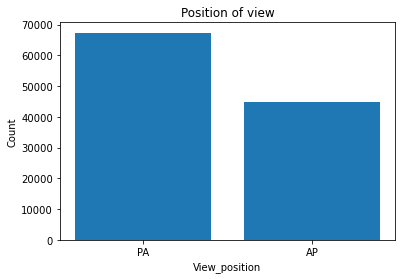

In [24]:
#Distribution of the x-ray view positions
View_position=all_xray_df['View Position'].value_counts()
plt.bar(View_position.index, View_position);
plt.title('Position of view')
plt.xlabel('View_position')
plt.ylabel('Count');

Text(0, 0.5, 'Count')

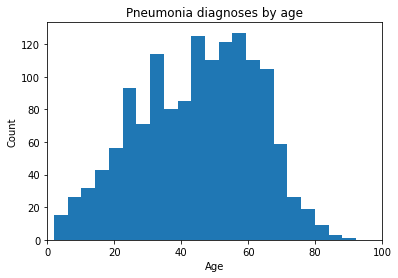

In [25]:
#Distribution of patients with pneumonia based oon their ages
plt.hist(all_xray_df[all_xray_df['Pneumonia'] ==1]['Patient Age'], bins =100);
plt.xlim(0,100)
plt.title('Pneumonia diagnoses by age')
plt.xlabel('Age')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

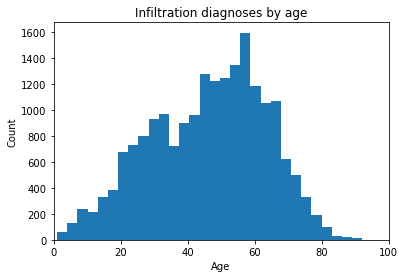

In [26]:
#Distribution patients with infiltration
plt.hist(all_xray_df[all_xray_df['Infiltration'] ==1]['Patient Age'], bins= 50);
plt.xlim(0,100)
plt.title('Infiltration diagnoses by age')
plt.xlabel('Age')
plt.ylabel('Count')


Text(0, 0.5, 'Count')

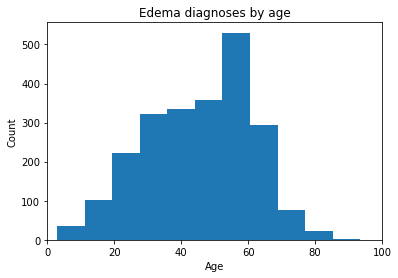

In [27]:
plt.hist(all_xray_df[all_xray_df['Edema'] ==1]['Patient Age'], bins= 50);
plt.xlim(0,100)
plt.title('Edema diagnoses by age')
plt.xlabel('Age')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

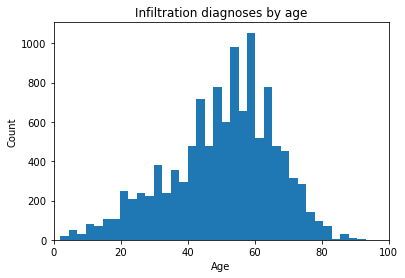

In [28]:
plt.hist(all_xray_df[all_xray_df['Atelectasis'] ==1]['Patient Age'], bins= 60);
plt.xlim(0,100)
plt.title('Infiltration diagnoses by age')
plt.xlabel('Age')
plt.ylabel('Count')

In [29]:
#My Findings:
# "No Findings" is the most common occurence followed by "Infiltration" and "Effusion"
#Some patients had several diagnoses with patient ID 10007 having the highest number of diagnoses
#"Pneumonia" co-existed with other diseases in many cases
#"Patient gender" and "Pateint age" were slightly inbalanced